# **Necessary Imports**

In [1]:
import shutil
import os
import random

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
from tensorflow.keras.saving import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.applications import RegNetX040
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# **Prepare Data**

In [5]:
# %cd '/kaggle/input/ukraine-ml-bootcamp-2023'
%cd '/kaggle/input/ml-bootcamp'

/kaggle/input/ml-bootcamp


In [7]:
data_table = pd.read_csv('train.csv')

In [8]:
def arrange_data(img_folder, tgt_folder, class_table):
    """
    arrange data into folders to feed it into ImageDataGenerator
    """
    for val in class_table['class_6'].unique():
        class_folder = os.path.join(tgt_folder, str(val))
        if not os.path.exists(class_folder):
            os.makedirs(class_folder)
    
    for index, (img_id, class_val) in class_table.iterrows():
        shutil.copy(os.path.join(img_folder, img_id), os.path.join(tgt_folder, str(class_val)))

In [9]:
os.makedirs('/kaggle/working/images')
os.makedirs('/kaggle/working/images/train')

In [10]:
arrange_data('./images/train_images', '/kaggle/working/images/train', data_table)

In [11]:
os.makedirs('/kaggle/working/images/validation')
for val in data_table['class_6'].unique():
    os.makedirs(os.path.join('/kaggle/working/images/validation', str(val)))

In [12]:
def train_test_split(train_folder, validation_folder, split_size=0.7):
    """
    Perform train-test splitting so that each class maintains its
    representation in both categories
    """
    for class_fldr in os.listdir(train_folder):
        folder = os.path.join(train_folder, class_fldr)
        num_imgs = len(os.listdir(folder))
        num_validation_imgs = num_imgs - int(split_size * num_imgs)
        mask = np.zeros((num_imgs,))
        mask[:num_validation_imgs] += 1
        random.shuffle(mask)
        for i, img in enumerate(os.listdir(folder)):
            if mask[i] == 1:
                shutil.move(os.path.join(folder, img),
                            os.path.join(validation_folder, class_fldr))

In [13]:
train_test_split(train_folder='/kaggle/working/images/train',
                 validation_folder='/kaggle/working/images/validation',
                 split_size=0.8)

In [14]:
# important constants
NUM_CLASSES = 6
EPOCHS = 10
BATCH_SIZE = 32

In [15]:
train_datagen = ImageDataGenerator(
    rotation_range=30,           # Random rotation up to 20 degrees
    width_shift_range=0.2,       # Random horizontal shift
    height_shift_range=0.2,      # Random vertical shift
    shear_range=0.2,             # Shear transformations
    zoom_range=0.3,              # Random zoom
    horizontal_flip=True,        # Random horizontal flip
    fill_mode='nearest'          # Fill strategy for new pixels
)
train_generator = train_datagen.flow_from_directory(
    '/kaggle/working/images/train',
    target_size=(400, 400),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 1887 images belonging to 6 classes.


In [16]:
validation_datagen = ImageDataGenerator()
validation_generator = validation_datagen.flow_from_directory(
    '/kaggle/working/images/validation',
    target_size=(400, 400),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 473 images belonging to 6 classes.


# **Create the Model**

In [17]:
input_shape = (400, 400, 3)

base_model = RegNetX040(weights='imagenet', include_top=False, input_shape=input_shape)

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model_regnet = Model(inputs=base_model.input, outputs=predictions)

model_regnet.summary()

84065032/84065032 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 regnetx040_prestem_rescaling (  (None, 400, 400, 3)  0          ['input_1[0][0]']                
 Rescaling)                                                                                       
                                                                                                  
 regnetx040_stem_conv (Conv2D)  (None, 200, 200, 32  864         ['regnetx040_prestem_rescaling[0]
                             

# **Train the Model**

In [18]:
checkpoint_path = "/kaggle/working/model.best.keras"
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='max')

In [19]:
model_regnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, weight_decay=1e-2),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])
history = model_regnet.fit(train_generator, epochs=EPOCHS, validation_data=validation_generator, callbacks=[checkpoint])

Epoch 1/10
59/59 [==============================] - ETA: 0s - loss: 1.3198 - accuracy: 0.4928
Epoch 1: val_accuracy improved from -inf to 0.58774, saving model to /kaggle/working/model.best.keras
59/59 [==============================] - 358s 4s/step - loss: 1.3198 - accuracy: 0.4928 - val_loss: 1.2483 - val_accuracy: 0.5877
Epoch 2/10
59/59 [==============================] - ETA: 0s - loss: 0.9268 - accuracy: 0.6635
Epoch 2: val_accuracy improved from 0.58774 to 0.67019, saving model to /kaggle/working/model.best.keras
59/59 [==============================] - 134s 2s/step - loss: 0.9268 - accuracy: 0.6635 - val_loss: 1.0219 - val_accuracy: 0.6702
Epoch 3/10
59/59 [==============================] - ETA: 0s - loss: 0.8195 - accuracy: 0.7022
Epoch 3: val_accuracy did not improve from 0.67019
59/59 [==============================] - 132s 2s/step - loss: 0.8195 - accuracy: 0.7022 - val_loss: 1.1817 - val_accuracy: 0.6173
Epoch 4/10
59/59 [==============================] - ETA: 0s - loss: 0.

In [20]:
loss_history = history.history['loss']
accuracy_history = history.history['accuracy']

In [22]:
model_regnet = load_model('/kaggle/working/model.best.keras')

In [23]:
model_regnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, weight_decay=1e-2),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])
history = model_regnet.fit(train_generator, epochs=EPOCHS, validation_data=validation_generator, callbacks=[checkpoint])

Epoch 1/10
59/59 [==============================] - ETA: 0s - loss: 0.2538 - accuracy: 0.9189
Epoch 1: val_accuracy improved from 0.78436 to 0.86047, saving model to /kaggle/working/model.best.keras
59/59 [==============================] - 182s 2s/step - loss: 0.2538 - accuracy: 0.9189 - val_loss: 0.4316 - val_accuracy: 0.8605
Epoch 2/10
59/59 [==============================] - ETA: 0s - loss: 0.1791 - accuracy: 0.9470
Epoch 2: val_accuracy improved from 0.86047 to 0.86681, saving model to /kaggle/working/model.best.keras
59/59 [==============================] - 133s 2s/step - loss: 0.1791 - accuracy: 0.9470 - val_loss: 0.4105 - val_accuracy: 0.8668
Epoch 3/10
59/59 [==============================] - ETA: 0s - loss: 0.1349 - accuracy: 0.9618
Epoch 3: val_accuracy improved from 0.86681 to 0.87315, saving model to /kaggle/working/model.best.keras
59/59 [==============================] - 133s 2s/step - loss: 0.1349 - accuracy: 0.9618 - val_loss: 0.4017 - val_accuracy: 0.8732
Epoch 4/10
59

In [24]:
loss_history.extend(history.history['loss'])
accuracy_history.extend(history.history['accuracy'])

In [25]:
model_regnet = load_model('/kaggle/working/model.best.keras')

In [26]:
model_regnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, weight_decay=1e-2),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])
hostory = model_regnet.fit(train_generator, epochs=EPOCHS, validation_data=validation_generator, callbacks=[checkpoint])

Epoch 1/10
59/59 [==============================] - ETA: 0s - loss: 0.1136 - accuracy: 0.9698
Epoch 1: val_accuracy did not improve from 0.87315
59/59 [==============================] - 180s 2s/step - loss: 0.1136 - accuracy: 0.9698 - val_loss: 0.4174 - val_accuracy: 0.8710
Epoch 2/10
59/59 [==============================] - ETA: 0s - loss: 0.1182 - accuracy: 0.9687
Epoch 2: val_accuracy did not improve from 0.87315
59/59 [==============================] - 132s 2s/step - loss: 0.1182 - accuracy: 0.9687 - val_loss: 0.4106 - val_accuracy: 0.8689
Epoch 3/10
59/59 [==============================] - ETA: 0s - loss: 0.0999 - accuracy: 0.9751
Epoch 3: val_accuracy did not improve from 0.87315
59/59 [==============================] - 131s 2s/step - loss: 0.0999 - accuracy: 0.9751 - val_loss: 0.4033 - val_accuracy: 0.8668
Epoch 4/10
59/59 [==============================] - ETA: 0s - loss: 0.1066 - accuracy: 0.9714
Epoch 4: val_accuracy did not improve from 0.87315
59/59 [=======================

In [27]:
model_regnet = load_model('/kaggle/working/model.best.keras')

In [28]:
loss_history.extend(history.history['loss'])
accuracy_history.extend(history.history['accuracy'])

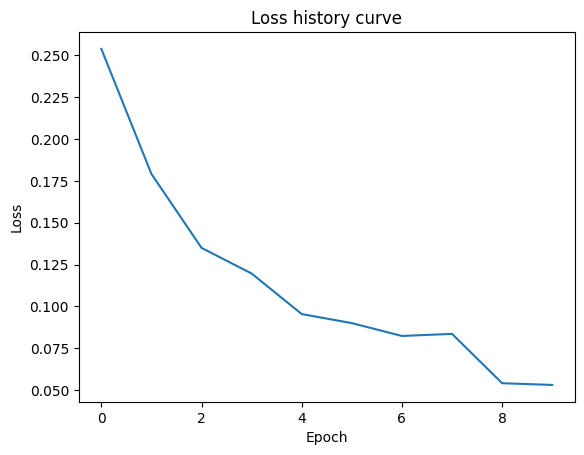

In [31]:
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss history curve')
plt.show()

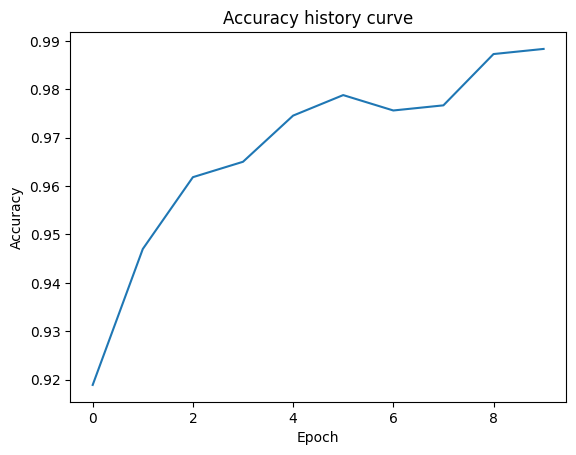

In [33]:
plt.plot(history.history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy history curve')
plt.show()

# **Submit the Model**

In [ ]:
submission = pd.read_csv('sample_submission.csv')

In [ ]:
test_dir = './images/test_images'
image_paths = [os.path.join(test_dir, filename) for filename in submission['image_id']]

test_df = pd.DataFrame({'image_path': image_paths})

In [ ]:
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col=None,
    target_size=(400, 400),
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False
)

predictions = model_regnet.predict(test_generator)

In [ ]:
classes_preds = np.argmax(predictions, axis=1)
submission['class_6'] = pd.Series(classes_preds)

In [ ]:
submission.to_csv('/kaggle/working/submission.csv', index=False)